In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import glob
from tabulate import tabulate
from tqdm import tqdm

In [3]:
import matplotlib.dates as dates
from scipy import stats
import pingouin as pg
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
from scipy.signal import chirp, find_peaks, peak_widths
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from statistics import mode

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [6]:
label_fontsize = 16 
title_fontsize = 18

In [7]:
basefolderdir = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
proboscisepochspath = basefolderdir + "drosSleepStages_SciAdvances2023/data/dlc_data/"
probosciseventspath = basefolderdir + "drosSleepStages_SciAdvances2023/data/dlc_data/"

In [8]:
stateepochsfolderpath = basefolderdir + "drosSleepStages_SciAdvances2023/data/epochs_data/"

In [9]:
basefilelist = ['02_27072018_SponSleep_LFP',
               '03_14092018_SponSleep_LFP',
               '04_17092018_SponSleep_LFP',
               '06_30102018_SponSleep_LFP',
               '07_01112018_SponSleep_LFP',
               '08_03112018_SponSleep_LFP',
               '09_13112018_SponSleep_LFP',
               '12_28112018_SponSleep_LFP',
               '14_11122018_SponSleep_LFP',
               '16_18122018_SponSleep_LFP',
               '17_10012019_SponSleep_LFP',
               '18_17012019_SponSleep_LFP',
               '19_22012019_SponSleep_LFP',
               '21_20022019_SponSleep_LFP'
              ]

In [10]:
len(basefilelist)

14

In [11]:
probcount_df = pd.DataFrame(columns=('dataset', 'singleprobs', 'multiprobs'))#'awakesingleprobs', 'awakemultiprobs','sleepsingleprobs', 'sleepmultiprobs'
probeventdict = {}

In [12]:
for basefileidx in range(len(basefilelist)): #len(basefilelist)range(1)
    indivflyname = basefilelist[basefileidx]
    print('Processing: ', indivflyname)
    epochscsvinputpath = proboscisepochspath
    epochscsvinputpath +=  indivflyname
    epochscsvinputpath = epochscsvinputpath + '/' + indivflyname[3:] + "_merged_proboscis_epochs.csv"
    probepochs_df = pd.read_csv(epochscsvinputpath)
    probepochs_df['Start_time'] = pd.to_datetime(probepochs_df['Start_time'], format='%Y-%m-%d %H:%M:%S')
    probepochs_df['End_time'] = pd.to_datetime(probepochs_df['End_time'], format='%Y-%m-%d %H:%M:%S')
    
    probepochs_df['event_count'] = 0
    probepochs_df['awake_count'] = 0
    probepochs_df['sleep_count'] = 0
    
    
    eventscsvinputpath = probosciseventspath + indivflyname + '/' + 'classifier_behannotation' + '/'
    verifframe_df = pd.read_csv(eventscsvinputpath + indivflyname[3:] + '_behclass_prob_pruned_verified.csv')
    
    verifframe_df = verifframe_df.loc[verifframe_df.true_event == 'yes']# take only true events..
    verifframe_df['frametime'] = pd.to_datetime(verifframe_df['frametime'], format='%Y-%m-%d %H:%M:%S')
    verifframe_df = verifframe_df.reset_index(drop=True) 
    
    for eventindex, eventrow in verifframe_df.iterrows():
        event_time = eventrow['frametime']
        for epochindex, epochrow in probepochs_df.iterrows():
            if (event_time >= epochrow['Start_time']) & (event_time <= epochrow['End_time']):
                #print('Target time: ', event_time)
                #print('match time: ', epochrow['Start_time'], epochrow['End_time'])
                probepochs_df.loc[epochindex,'event_count'] +=1
                
                if epochrow['Type'] == 'awakeprob':
                    probepochs_df.loc[epochindex,'awake_count'] +=1 
                elif epochrow['Type'] == 'sleepprob':
                    probepochs_df.loc[epochindex,'sleep_count'] +=1 
                
                break
    
    overallsingleprobs = np.sum(probepochs_df['event_count'] == 1)
    overallmultiprobs = np.sum(probepochs_df['event_count'] > 1)
    
    awakesingleprobs = np.sum(probepochs_df['awake_count'] == 1)
    awakemultiprobs = np.sum(probepochs_df['awake_count'] > 1)
    
    sleepsingleprobs = np.sum(probepochs_df['sleep_count'] == 1)
    sleepmultiprobs = np.sum(probepochs_df['sleep_count'] > 1)
    
    probeventdict[indivflyname[3:]] = probepochs_df.loc[probepochs_df['event_count'] >=1,'event_count'].values
    
    probcount_df = probcount_df.append({'dataset': indivflyname[3:], 'singleprobs':  overallsingleprobs, 'multiprobs':  overallmultiprobs,
                                        }, ignore_index=True)

Processing:  02_27072018_SponSleep_LFP
Processing:  03_14092018_SponSleep_LFP
Processing:  04_17092018_SponSleep_LFP
Processing:  06_30102018_SponSleep_LFP
Processing:  07_01112018_SponSleep_LFP
Processing:  08_03112018_SponSleep_LFP
Processing:  09_13112018_SponSleep_LFP
Processing:  12_28112018_SponSleep_LFP
Processing:  14_11122018_SponSleep_LFP
Processing:  16_18122018_SponSleep_LFP
Processing:  17_10012019_SponSleep_LFP
Processing:  18_17012019_SponSleep_LFP
Processing:  19_22012019_SponSleep_LFP
Processing:  21_20022019_SponSleep_LFP


In [13]:
probcount_df = probcount_df.rename(columns={'singleprobs': 'single', 'multiprobs': 'multi'})
probcount_df

,dataset,single,multi
0,27072018_SponSleep_LFP,41,66
1,14092018_SponSleep_LFP,15,42
2,17092018_SponSleep_LFP,8,35
3,30102018_SponSleep_LFP,3,17
4,01112018_SponSleep_LFP,10,9
5,03112018_SponSleep_LFP,6,13
6,13112018_SponSleep_LFP,2,11
7,28112018_SponSleep_LFP,12,19
8,11122018_SponSleep_LFP,8,52
9,18122018_SponSleep_LFP,42,108


In [14]:
combprobcount_df = pd.melt(probcount_df, id_vars=['dataset'])
combprobcount_df = combprobcount_df.rename(columns={'variable': 'type','value': 'count'})
combprobcount_df['count'] = combprobcount_df['count'].astype(float)
combprobcount_df

,dataset,type,count
0,27072018_SponSleep_LFP,single,41.0
1,14092018_SponSleep_LFP,single,15.0
2,17092018_SponSleep_LFP,single,8.0
3,30102018_SponSleep_LFP,single,3.0
4,01112018_SponSleep_LFP,single,10.0
5,03112018_SponSleep_LFP,single,6.0
6,13112018_SponSleep_LFP,single,2.0
7,28112018_SponSleep_LFP,single,12.0
8,11122018_SponSleep_LFP,single,8.0
9,18122018_SponSleep_LFP,single,42.0


In [15]:
pg.sphericity(data=combprobcount_df, dv='count', within='type', subject='dataset')

(True, nan, nan, 1, 1.0)

In [16]:
res = pg.rm_anova(dv='count', within='type',subject='dataset', data=combprobcount_df, detailed=True, 
                  effsize="ng2", correction = True)

In [17]:
res

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,type,2642.285714,1,2642.285714,13.807741,0.00259,0.130284,1.0
1,Error,2487.714286,13,191.362637,NaN,NaN,NaN,NaN


In [18]:
res = pg.pairwise_ttests(dv='count', within='type',subject='dataset', data=combprobcount_df, effsize = 'cohen')
res

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,type,multi,single,True,True,3.715877,13.0,two-sided,0.00259,17.457,0.745923


In [19]:
typepal = {'single':'lightcoral', 'multi': 'teal'}

In [20]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [21]:
def statannotation(ax, x1, x2, y,text, h = 2):
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

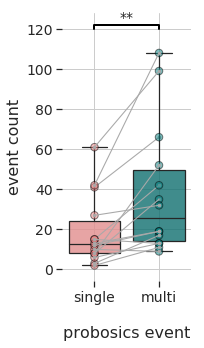

In [22]:
f, (ax1) = plt.subplots(ncols=1, sharex=True,figsize=(3, 5))

ax2 = sns.pointplot(x="type",y="count",hue='dataset',data=combprobcount_df,ax=ax1, dodge=0.0,
                    palette=['darkgray'])

sns.boxplot(x="type",y="count",data = combprobcount_df, whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette = typepal)
sns.stripplot(x="type",y="count",data = combprobcount_df, jitter=False, linewidth=1, ax=ax1,
              edgecolor ="black",palette=typepal, marker='o', s= 7.5, alpha = 0.5)


# string_val = 't(' + str(np.round(res['dof'].values[0],2)) + ')= ' + \
#              str(np.round(res['T'].values[0],2)) + \
#              ', p' + ' <0.01**' + "\nCohens'd: " + str(np.round(res['cohen'].values[0],2))

string_val = '**'

statannotation(ax = ax1, x1 = 0, x2 = 1, y = 120, text = string_val)


ax1.legend_.remove()
b = list(ax1.get_children())

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

plt.ylabel('event count', fontsize=label_fontsize)
plt.xlabel('\nprobosics event', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.tight_layout()
plt.box(False)
plt.grid(True)

In [23]:
merged_df = None

In [24]:
for dataset in probeventdict:
    unique, counts = np.unique(probeventdict[dataset], return_counts=True)
    temp_df = pd.DataFrame({'probevent':unique.tolist(), 'count':counts})
    temp_df['count'] = temp_df['count'] / temp_df['count'].sum()
    temp_df = temp_df.rename(columns={'count': dataset[0:8]})
    if merged_df is None:
        merged_df = temp_df
    else:
        merged_df = pd.merge(merged_df, temp_df, on='probevent', how = 'outer')

In [25]:
plotmerged_df = merged_df[merged_df.probevent <15]
plotmerged_df = plotmerged_df.append(merged_df[merged_df.probevent>=15].sum(), ignore_index = True)
plotmerged_df.loc[plotmerged_df.index[-1], 'probevent'] = 15
plotmerged_df = plotmerged_df.drop('probevent',1)
plotmerged_df

,27072018,14092018,17092018,30102018,01112018,03112018,13112018,28112018,11122018,18122018,10012019,17012019,22012019,20022019
0,0.383178,0.263158,0.186047,0.15,0.526316,0.315789,0.153846,0.387097,0.133333,0.280000,0.40625,0.535714,0.457627,0.38125
1,0.168224,0.280702,0.186047,0.15,0.210526,0.157895,0.076923,0.161290,0.083333,0.160000,0.18750,0.071429,0.135593,0.09375
2,0.074766,0.035088,0.116279,0.10,NaN,0.210526,0.153846,0.032258,0.066667,0.173333,0.21875,0.035714,0.067797,0.04375
3,0.084112,0.052632,0.116279,0.10,0.105263,NaN,0.076923,0.096774,0.133333,0.066667,NaN,0.035714,0.033898,0.01875
4,0.056075,NaN,NaN,0.10,0.157895,0.052632,NaN,NaN,0.133333,0.053333,0.06250,NaN,0.084746,0.05625
5,0.056075,0.017544,0.093023,0.05,NaN,NaN,0.076923,0.032258,0.083333,0.040000,NaN,0.035714,0.050847,0.04375
6,0.037383,0.035088,0.093023,0.10,NaN,0.105263,NaN,NaN,0.100000,0.053333,0.03125,0.071429,0.016949,0.01250
7,0.084112,0.017544,0.023256,0.10,NaN,NaN,0.076923,NaN,0.033333,0.026667,NaN,NaN,0.033898,0.05625
8,0.009346,0.035088,0.046512,0.05,NaN,0.105263,NaN,0.032258,NaN,0.006667,NaN,NaN,NaN,0.02500
9,0.009346,NaN,0.046512,NaN,NaN,NaN,NaN,0.032258,0.066667,0.020000,0.06250,0.035714,0.016949,0.01875


In [26]:
plotprobevents_df = {'mean':plotmerged_df.mean(axis = 1),'sem':  plotmerged_df.sem(axis = 1)}
plotprobevents_df = pd.DataFrame(plotprobevents_df)
plotprobevents_df  = plotprobevents_df.rename_axis('probevents').reset_index()
plotprobevents_df.probevents +=1
plotprobevents_df

,probevents,mean,sem
0,1,0.325686,0.036421
1,2,0.151658,0.015436
2,3,0.102213,0.018550
3,4,0.076695,0.010350
4,5,0.084085,0.012957
5,6,0.052679,0.006979
6,7,0.059656,0.010695
7,8,0.050220,0.010054
8,9,0.038767,0.010978
9,10,0.034300,0.006840


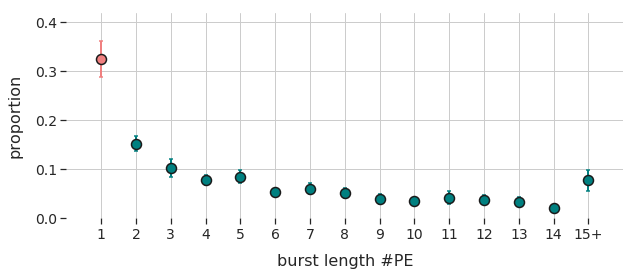

In [27]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.errorbar(x = 'probevents', y = 'mean', yerr='sem', data = plotprobevents_df[plotprobevents_df.probevents == 1], 
            fmt='o', ls = '', color = 'lightcoral', markersize=10,
            capsize = 2, mec='k',elinewidth=2, markeredgewidth=1.5)
ax.errorbar(x = 'probevents', y = 'mean', yerr='sem', data = plotprobevents_df[plotprobevents_df.probevents > 1], 
            fmt='o', ls = '', color = 'teal', markersize=10,
            capsize = 2, mec='k',elinewidth=2, markeredgewidth=1.5)
xticklocs = np.arange(1,16, step = 1)
ax.set_xlim([0, 16])
ax.set_ylim([0, 0.42])
tickval = np.arange(1,16, step = 1)
tickval = list(map(str,tickval))
tickval[-1] = '15+'
plt.xticks(xticklocs, tickval)
ax.set_xlabel('burst length #PE', rotation=0,ha='center',va='center', fontsize=label_fontsize, labelpad=20)
ax.set_ylabel('proportion', rotation=90,ha='center',va='center', fontsize=label_fontsize, labelpad=20)
sns.despine(left=False, bottom=False, right=True)

ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.tight_layout()
plt.box(True)
plt.grid(True)

ax.grid(True)
sns.despine(left=True, bottom=True, right=True)

In [28]:
allprobepochs_df = pd.DataFrame()

In [29]:
for basefileidx in range(len(basefilelist)): #len(basefilelist)range(1)
    indivflyname = basefilelist[basefileidx]
    print('Processing: ', indivflyname)
    epochscsvinputpath = proboscisepochspath
    epochscsvinputpath +=  indivflyname
    epochscsvinputpath = epochscsvinputpath + '/' + indivflyname[3:] + "_merged_proboscis_epochs.csv"
    probepochs_df = pd.read_csv(epochscsvinputpath)
    probepochs_df['Start_time'] = pd.to_datetime(probepochs_df['Start_time'], format='%Y-%m-%d %H:%M:%S')
    probepochs_df['End_time'] = pd.to_datetime(probepochs_df['End_time'], format='%Y-%m-%d %H:%M:%S')
    
    probepochs_df['event_count'] = 0
    probepochs_df['awake_count'] = 0
    probepochs_df['sleep_count'] = 0
    probepochs_df['depth'] = 0
    probepochs_df['depthcat'] = 'NA'
    
    
    eventscsvinputpath = probosciseventspath + indivflyname + '/' + 'classifier_behannotation' + '/'
    verifframe_df = pd.read_csv(eventscsvinputpath + indivflyname[3:] + '_behclass_prob_pruned_verified.csv')
    
    verifframe_df = verifframe_df.loc[verifframe_df.true_event == 'yes']# take only true events..
    verifframe_df['frametime'] = pd.to_datetime(verifframe_df['frametime'], format='%Y-%m-%d %H:%M:%S')
    verifframe_df = verifframe_df.reset_index(drop=True) 
    
    for eventindex, eventrow in verifframe_df.iterrows():
        event_time = eventrow['frametime']
        for epochindex, epochrow in probepochs_df.iterrows():
            if (event_time >= epochrow['Start_time']) & (event_time <= epochrow['End_time']):
#                 print('Target time: ', event_time)
#                 print('match time: ', epochrow['Start_time'], epochrow['End_time'])
                probepochs_df.loc[epochindex,'event_count'] +=1
                
                if epochrow['Type'] == 'awakeprob':
                    probepochs_df.loc[epochindex,'awake_count'] +=1 
                elif epochrow['Type'] == 'sleepprob':
                    probepochs_df.loc[epochindex,'sleep_count'] +=1 
                    
                
                break
                
    stateepochscsvpath = stateepochsfolderpath + '/' + indivflyname[3:] + '_merged_epochs.csv'
    stateepochs_df = pd.read_csv(stateepochscsvpath)
    stateepochs_df['Start_time'] = pd.to_datetime(stateepochs_df['Start_time'], format='%Y-%m-%d %H:%M:%S')
    stateepochs_df['End_time'] = pd.to_datetime(stateepochs_df['End_time'], format='%Y-%m-%d %H:%M:%S')
    
    
    for probeventindex, probeventrow in probepochs_df.iterrows():
        probstart_time = probeventrow['Start_time']
        probend_time = probeventrow['End_time']
        for stateepochindex, stateepochrow in stateepochs_df.iterrows():
            if ((probstart_time >= stateepochrow['Start_time']) & (probstart_time <= stateepochrow['End_time']) &\
                (probend_time >= stateepochrow['Start_time'])   & (probend_time <= stateepochrow['End_time'])):
#                 print('Prob target time: ', probstart_time)
#                 print('match time: ', stateepochrow['Start_time'], stateepochrow['End_time'])
                                                                  
                depth = (probstart_time - stateepochrow['Start_time']).total_seconds()
                # the sleep epochs are shifted by 1 sec
                probepochs_df.loc[probeventindex,'depth'] = depth/60
                
                if depth/60 > 5:
                    probepochs_df.loc[probeventindex,'depthcat'] = '>5min' 
                else:
                    probepochs_df.loc[probeventindex,'depthcat'] = '0-5min' 
                
                break
                
    probepochs_df = probepochs_df.loc[probepochs_df['Type'].isin(['awakeprob', 'sleepprob','intransprob'])]
    probepochs_df = probepochs_df[['Type', 'event_count', 'depth', 'depthcat']]
    probepochs_df['probtype'] = probepochs_df['event_count'].map(lambda x: 'single' \
                                                                 if x == 1 else ('NA' if x == 0 else 'multi'))
    
    probepochs_df.rename(columns={'Type': 'statetype'}, inplace=True)
    
    probepochs_df = probepochs_df.groupby(['statetype','depthcat']).agg({'event_count': 'sum'}).reset_index()
    probepochs_df['dataset'] = indivflyname
    
    allprobepochs_df = allprobepochs_df.append(probepochs_df)

Processing:  02_27072018_SponSleep_LFP
Processing:  03_14092018_SponSleep_LFP
Processing:  04_17092018_SponSleep_LFP
Processing:  06_30102018_SponSleep_LFP
Processing:  07_01112018_SponSleep_LFP
Processing:  08_03112018_SponSleep_LFP
Processing:  09_13112018_SponSleep_LFP
Processing:  12_28112018_SponSleep_LFP
Processing:  14_11122018_SponSleep_LFP
Processing:  16_18122018_SponSleep_LFP
Processing:  17_10012019_SponSleep_LFP
Processing:  18_17012019_SponSleep_LFP
Processing:  19_22012019_SponSleep_LFP
Processing:  21_20022019_SponSleep_LFP


In [30]:
allprobepochs_df.head()

,statetype,depthcat,event_count,dataset
0,awakeprob,0-5min,73,02_27072018_SponSleep_LFP
1,awakeprob,>5min,66,02_27072018_SponSleep_LFP
2,intransprob,0-5min,16,02_27072018_SponSleep_LFP
3,sleepprob,0-5min,55,02_27072018_SponSleep_LFP
4,sleepprob,>5min,159,02_27072018_SponSleep_LFP


In [31]:
awakeprobepochs_df = allprobepochs_df[allprobepochs_df.statetype == 'awakeprob']
statsawakeprobepochs_df = awakeprobepochs_df.pivot_table('event_count', ['dataset', 'statetype'], 'depthcat')
# replace zeros with nan..
statsawakeprobepochs_df = statsawakeprobepochs_df.replace(0, np.nan)
statsawakeprobepochs_df = statsawakeprobepochs_df.dropna(how='all', axis=0)
statsawakeprobepochs_df = statsawakeprobepochs_df.replace(np.nan, 0)

In [32]:
sleepprobepochs_df = allprobepochs_df[allprobepochs_df.statetype == 'sleepprob']
statssleepprobepochs_df = sleepprobepochs_df.pivot_table('event_count', ['dataset', 'statetype'], 'depthcat')
# replace zeros with nan..
statssleepprobepochs_df = statssleepprobepochs_df.replace(0, np.nan)
statssleepprobepochs_df = statssleepprobepochs_df.dropna(how='all', axis=0)
statssleepprobepochs_df = statssleepprobepochs_df.replace(np.nan, 0)

In [33]:
plotawakeprobepochs_df = statsawakeprobepochs_df.stack([0], dropna = False).reset_index(name='value')
plotsleepprobepochs_df = statssleepprobepochs_df.stack([0], dropna = False).reset_index(name='value')

In [34]:
plotsleepprobepochs_df.head()

,dataset,statetype,depthcat,value
0,02_27072018_SponSleep_LFP,sleepprob,0-5min,55.0
1,02_27072018_SponSleep_LFP,sleepprob,>5min,159.0
2,03_14092018_SponSleep_LFP,sleepprob,0-5min,0.0
3,03_14092018_SponSleep_LFP,sleepprob,>5min,27.0
4,04_17092018_SponSleep_LFP,sleepprob,0-5min,4.0


In [35]:
res_sleep = pg.rm_anova(dv='value', within='depthcat',subject='dataset', data=plotsleepprobepochs_df, 
                        detailed=True, effsize="ng2", correction = True)
res_sleep

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,depthcat,4368.038462,1,4368.038462,7.823981,0.01613,0.128521,1.0
1,Error,6699.461538,12,558.288462,NaN,NaN,NaN,NaN


In [36]:
res_sleep = pg.pairwise_ttests(dv='value', within='depthcat',subject='dataset', data=plotsleepprobepochs_df, 
                               effsize = 'cohen')
res_sleep

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,depthcat,0-5min,>5min,True,True,-2.797138,12.0,two-sided,0.01613,3.933,-0.737917


In [37]:
res_awake = pg.rm_anova(dv='value', within='depthcat',subject='dataset', data=plotawakeprobepochs_df, 
                        detailed=True, effsize="ng2", correction = True)
res_awake

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,depthcat,3.222863e+05,1,322286.285714,3.672757,0.077556,0.120005,1.0
1,Error,1.140757e+06,13,87750.516484,NaN,NaN,NaN,NaN


In [38]:
res_awake = pg.pairwise_ttests(dv='value', within='depthcat',subject='dataset', data=plotawakeprobepochs_df, 
                               effsize = 'cohen')
res_awake

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,depthcat,0-5min,>5min,True,True,-1.916444,13.0,two-sided,0.077556,1.128,-0.711701


In [39]:
awakestatetypepal = {'0-5min':'darksalmon', '>5min': 'saddlebrown'}
sleepstatetypepal = {'0-5min':'cornflowerblue', '>5min': 'darkblue'}

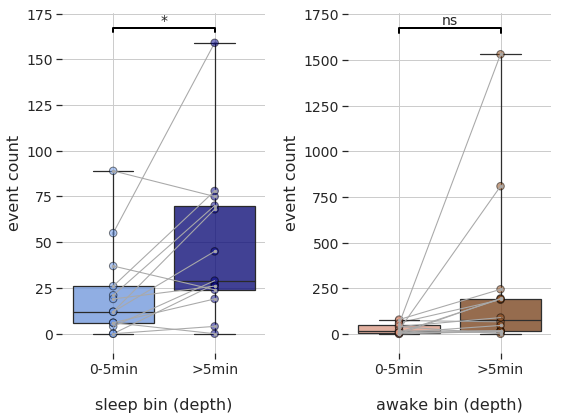

In [40]:
f, (ax2, ax1) = plt.subplots(ncols=2, figsize=(4*2, 6))

ax1 = sns.pointplot(x="depthcat",y="value",hue='dataset',data=plotawakeprobepochs_df,ax=ax1, dodge=0.0,
                    palette=['darkgray'])

sns.boxplot(x="depthcat",y="value",data = plotawakeprobepochs_df, whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette = awakestatetypepal)
sns.stripplot(x="depthcat",y="value",data = plotawakeprobepochs_df, jitter=False, linewidth=1, ax=ax1,
              edgecolor ="black",palette=awakestatetypepal, marker='o', s= 7.5, alpha = 0.5)


# string_val = 't(' + str(np.round(res_awake['dof'].values[0],2)) + ')= ' + \
#              str(np.round(res_awake['T'].values[0],2)) + \
#              ', p' + ' >0.05' + "\nCohens'd: " + str(np.round(np.abs(res_awake['cohen'].values[0]),2))

string_val = 'ns'

statannotation(ax = ax1, x1 = 0, x2 = 1, y = 1650, text = string_val, h = 25)


ax1.legend_.remove()
b = list(ax1.get_children())

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.set_ylabel('event count', fontsize=label_fontsize)
ax1.set_xlabel('\nawake bin (depth)', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)



ax2 = sns.pointplot(x="depthcat",y="value",hue='dataset',data=plotsleepprobepochs_df,ax=ax2, dodge=0.0,
                    palette=['darkgray'])

sns.boxplot(x="depthcat",y="value",data = plotsleepprobepochs_df, whis=np.inf, ax=ax2, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette = sleepstatetypepal)
sns.stripplot(x="depthcat",y="value",data = plotsleepprobepochs_df, jitter=False, linewidth=1, ax=ax2,
              edgecolor ="black",palette=sleepstatetypepal, marker='o', s= 7.5, alpha = 0.5)


# string_val = 't(' + str(np.round(res_sleep['dof'].values[0],2)) + ')= ' + \
#              str(np.round(res_sleep['T'].values[0],2)) + \
#              ', p' + ' <0.05*' + "\nCohens'd: " + str(np.round(np.abs(res_sleep['cohen'].values[0]),2))

string_val = '*'

statannotation(ax = ax2, x1 = 0, x2 = 1, y = 165, text = string_val)


ax2.legend_.remove()
b = list(ax2.get_children())

for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax2.set_ylabel('event count', fontsize=label_fontsize)
ax2.set_xlabel('\nsleep bin (depth)', fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax2.grid(True)


plt.tight_layout()
plt.box(False)

In [41]:
timelabel_dict ={-5:'awake',
                 -1.5:'-2:-1',
                 -0.5:'-1:+0',0.5:'+0:+1',1.5:'+1:+2',
                  5: 'midsleep',
                 8.5:'x:-2',9.5:'x:-1'}

In [42]:
timelabel_dict2 ={-5:'awake',
                 -1.5:'intrans',
                 -0.5:'intrans',0.5:'sleep',1.5:'sleep',
                  5: 'sleep',
                 8.5:'sleep',9.5:'sleep'}

In [43]:
allprobbincount_df = []

In [44]:
allprobdepthcounts = []
allprobdepthcats = []

In [45]:
for basefileidx in range(len(basefilelist)): #len(basefilelist)range(1)
    indivflyname = basefilelist[basefileidx]
    print('Processing: ', indivflyname)
     
    # get the state table with the start and end times with awake, sleep etc
    epochscsvpath = stateepochsfolderpath + '/' + indivflyname[3:] + '_merged_epochs.csv'
    stateepochs_df = pd.read_csv(epochscsvpath)
    stateepochs_df['Start_time'] = pd.to_datetime(stateepochs_df['Start_time'], format='%Y-%m-%d %H:%M:%S')
    stateepochs_df['End_time'] = pd.to_datetime(stateepochs_df['End_time'], format='%Y-%m-%d %H:%M:%S')
    
    
    stateepochs_df['Duration'] = (stateepochs_df['End_time'] - stateepochs_df['Start_time'])
    stateepochs_df2 = stateepochs_df.copy()
    stateepochs_df['Duration'] = stateepochs_df['Duration'].astype(str)
    stateepochs_df['Duration'] = stateepochs_df['Duration'].map(lambda x: x[7:])
    
    
    countvals = stateepochs_df2['Type'].value_counts()
    stateepochs_df2 = stateepochs_df2.groupby(["Type"]).Duration.sum().reset_index()
    stateepochs_df2['duration'] = stateepochs_df2['Duration'].map(lambda x: x.total_seconds()/60)
    stateepochs_df2 = stateepochs_df2.rename(columns = {'Type':'type'})
    stateepochs_df2 = stateepochs_df2.drop('Duration', axis=1)


    
    eventscsvinputpath = probosciseventspath + indivflyname + '/' + 'classifier_behannotation' + '/'
    verifframe_df = pd.read_csv(eventscsvinputpath + indivflyname[3:] + '_behclass_prob_pruned_verified.csv')
    
    verifframe_df = verifframe_df.loc[verifframe_df.true_event == 'yes']# take only true events..
    verifframe_df = verifframe_df.loc[(verifframe_df.state == 'sleep') |\
                                      (verifframe_df.state == 'intrans')]# take only sleep, intrans events..
    verifframe_df['frametime'] = pd.to_datetime(verifframe_df['frametime'], format='%Y-%m-%d %H:%M:%S')
    verifframe_df = verifframe_df.reset_index(drop=True)
    
    verifframe_df['fly'] = indivflyname[3:]
    verifframe_df['bintype'] = 'NA'
    verifframe_df['binstart'] = np.nan
    verifframe_df['binend'] = np.nan
    verifframe_df['depth_start'] = np.nan
    verifframe_df['depth_end'] = np.nan
    verifframe_df['depth_cat'] = np.nan
    verifframe_df = verifframe_df.drop(['diff','notes','frame', 'likelihood', 'true_event'], axis=1)
    
    # find the bin values for each prob event now..
    for index, row in verifframe_df.iterrows():
        for stateindex, staterow in stateepochs_df.iterrows():
            if (row['frametime'] >= staterow['Start_time']) and (row['frametime']<= staterow['End_time']):
                verifframe_df.loc[index,'binstart'] = staterow['Start_time']
                verifframe_df.loc[index,'binend'] = staterow['End_time']
                verifframe_df.loc[index,'bintype'] = staterow['Type']
                verifframe_df.loc[index,'depth_start'] = verifframe_df.loc[index,'frametime'] -\
                                                      staterow['Start_time']
                verifframe_df.loc[index,'depth_start'] = verifframe_df.loc[index,'depth_start'].seconds/60

                verifframe_df.loc[index,'depth_end'] = staterow['End_time'] -\
                                                       verifframe_df.loc[index,'frametime']                                   
                verifframe_df.loc[index,'depth_end'] = verifframe_df.loc[index,'depth_end'].seconds/60
                
                verifframe_df.loc[index,'depth_duration'] = staterow['End_time'] - staterow['Start_time']
                verifframe_df.loc[index,'depth_duration'] = verifframe_df.loc[index,'depth_duration'].seconds/60
                verifframe_df.loc[index,'depth_duration'] = verifframe_df.loc[index,'depth_start']/verifframe_df.loc[index,'depth_duration']
                

                verifframe_df.loc[index,'depth_duration2'] = staterow['End_time'] - staterow['Start_time']
                verifframe_df.loc[index,'depth_duration2'] = verifframe_df.loc[index,'depth_duration2'].seconds/60
                verifframe_df.loc[index,'depth_duration2'] = verifframe_df.loc[index,'depth_end']/verifframe_df.loc[index,'depth_duration2']
                
                
                if verifframe_df.loc[index,'bintype'] == 'intrans':
                    if verifframe_df.loc[index,'depth_start'] >= 1:
                        verifframe_df.loc[index,'depth_cat'] = -0.5 #'04min_intrans'
                    else:
                        verifframe_df.loc[index,'depth_cat'] = -1.5 #'03min_intrans'
                elif verifframe_df.loc[index,'bintype'] == 'sleep':
                    if  verifframe_df.loc[index,'depth_start'] >= 2:
                        if verifframe_df.loc[index,'depth_end'] < 1:
                            verifframe_df.loc[index,'depth_cat'] = 9.5 #'02min_outtrans'
                        elif verifframe_df.loc[index,'depth_end'] < 2:
                            verifframe_df.loc[index,'depth_cat'] = 8.5 #'01min_outtrans'
                        else:
                            verifframe_df.loc[index,'depth_cat'] = 5 #'sleep'
                    elif verifframe_df.loc[index,'depth_start'] >= 1:
                        verifframe_df.loc[index,'depth_cat'] = 1.5 #'06min_intrans'
                    elif verifframe_df.loc[index,'depth_start'] < 1:
                        verifframe_df.loc[index,'depth_cat'] = 0.5 #'05min_intrans'
                elif verifframe_df.loc[index,'bintype'] == 'awake':
                    verifframe_df.loc[index,'depth_cat'] = -5 #'awake'

                break
                    
    probbincount_df = verifframe_df['depth_cat'].value_counts(normalize=True).rename_axis('time').reset_index(name='counts')
    probbincount_df['dataset'] = indivflyname[3:]
    probbincount_df['time_label'] = probbincount_df['time'].map(timelabel_dict)
    probbincount_df['type'] = probbincount_df['time'].map(timelabel_dict2)
    
#     probbincount_df2 = pd.merge(probbincount_df, stateepochs_df2, on='type')
#     probbincount_df2['normdur'] = np.nan
    
#     for probindex, probrow in probbincount_df2.iterrows():
#         if probrow['time_label'] == 'awake':
#             probbincount_df2.loc[probindex,'normdur'] = probbincount_df2.loc[probindex,'duration']
#         elif (probrow['time_label'] == '-2:-1')|(probrow['time_label'] == '-1:+0'):
#             probbincount_df2.loc[probindex,'normdur'] = countvals['intrans']
#         elif (probrow['time_label'] == '+0:+1')|(probrow['time_label'] == '+1:+2'):
#             probbincount_df2.loc[probindex,'normdur'] = countvals['sleep']
#         elif (probrow['time_label'] == 'x:-2')|(probrow['time_label'] == 'x:-1'):
#             probbincount_df2.loc[probindex,'normdur'] = countvals['sleep']
#         elif probrow['time_label'] == 'midsleep':
#             probbincount_df2.loc[probindex,'normdur'] = probbincount_df2.loc[probindex,'duration'] - 4*countvals['sleep']
    
#     probbincount_df2['countpermin'] = probbincount_df2['counts']/probbincount_df2['normdur']

   
    verifframe_df = verifframe_df.loc[(verifframe_df.bintype == 'sleep')]
    probdepthcounts = verifframe_df['depth_start'].values.tolist()
    probdepthcats = verifframe_df['depth_cat'].values.tolist()
    
    
    if basefileidx == 0:
        allprobbincount_df = probbincount_df
        allprobdepthcounts = probdepthcounts
        allprobdepthcats = probdepthcats
    else:
        allprobbincount_df = allprobbincount_df.append(probbincount_df)
        allprobdepthcounts.extend(probdepthcounts)
        allprobdepthcats.extend(probdepthcats)       

Processing:  02_27072018_SponSleep_LFP
Processing:  03_14092018_SponSleep_LFP
Processing:  04_17092018_SponSleep_LFP
Processing:  06_30102018_SponSleep_LFP
Processing:  07_01112018_SponSleep_LFP
Processing:  08_03112018_SponSleep_LFP
Processing:  09_13112018_SponSleep_LFP
Processing:  12_28112018_SponSleep_LFP
Processing:  14_11122018_SponSleep_LFP
Processing:  16_18122018_SponSleep_LFP
Processing:  17_10012019_SponSleep_LFP
Processing:  18_17012019_SponSleep_LFP
Processing:  19_22012019_SponSleep_LFP
Processing:  21_20022019_SponSleep_LFP


In [46]:
verifframe_df

,hour,frametime,state,fly,bintype,binstart,binend,depth_start,depth_end,depth_cat,depth_duration,depth_duration2
0,2,2019-02-20 10:22:28,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 10:17:03,2019-02-20 10:22:28,5.41667,0,9.5,1,0
15,3,2019-02-20 10:55:29,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 10:45:55,2019-02-20 11:13:33,9.56667,18.0667,5.0,0.3462,0.6538
16,3,2019-02-20 10:56:01,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 10:45:55,2019-02-20 11:13:33,10.1,17.5333,5.0,0.365501,0.634499
17,3,2019-02-20 11:03:31,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 10:45:55,2019-02-20 11:13:33,17.6,10.0333,5.0,0.636912,0.363088
18,3,2019-02-20 11:03:34,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 10:45:55,2019-02-20 11:13:33,17.65,9.98333,5.0,0.638721,0.361279
...,...,...,...,...,...,...,...,...,...,...,...,...
112,8,2019-02-20 16:32:52,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 16:26:56,2019-02-20 16:33:03,5.93333,0.183333,9.5,0.970027,0.0299728
113,8,2019-02-20 16:32:55,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 16:26:56,2019-02-20 16:33:03,5.98333,0.133333,9.5,0.978202,0.0217984
114,8,2019-02-20 16:32:58,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 16:26:56,2019-02-20 16:33:03,6.03333,0.0833333,9.5,0.986376,0.013624
115,8,2019-02-20 16:33:00,sleep,20022019_SponSleep_LFP,sleep,2019-02-20 16:26:56,2019-02-20 16:33:03,6.06667,0.05,9.5,0.991826,0.00817439


In [47]:
verifframe_df['state'].unique()

array(['sleep'], dtype=object)

In [48]:
allprobbincount_df.head()

,time,counts,dataset,time_label,type
0,5.0,0.569565,27072018_SponSleep_LFP,midsleep,sleep
1,9.5,0.243478,27072018_SponSleep_LFP,x:-1,sleep
2,8.5,0.069565,27072018_SponSleep_LFP,x:-2,sleep
3,-1.5,0.047826,27072018_SponSleep_LFP,-2:-1,intrans
4,1.5,0.034783,27072018_SponSleep_LFP,+1:+2,sleep


In [49]:
kwargs  =   {'edgecolor':"black", # for edge color
             'linewidth':1, # line width of spot
             'linestyle':'-', # line style of spot
            }

In [50]:
color_dict = dict({'awake':'#B34D4D',
                    '-2:-1':'#F2AF0D','-1:+0':'#F2AF0D',
                   '+0:+1':'#1AC2E6','+1:+2':'#1AC2E6',
                   'midsleep':'#0D28F2',
                   'x:-2':'#B3704D','x:-1':'#B3704D',
                  })

In [51]:
allprobbincount_df['time_label'] = allprobbincount_df['time'].map(timelabel_dict)
allprobbincount_df = allprobbincount_df.sort_values(by=['time'])

In [52]:
allprobbincount_df.head()

,time,counts,dataset,time_label,type
3,-1.5,0.028571,11122018_SponSleep_LFP,-2:-1,intrans
3,-1.5,0.047826,27072018_SponSleep_LFP,-2:-1,intrans
3,-1.5,0.016949,03112018_SponSleep_LFP,-2:-1,intrans
0,-1.5,0.555556,01112018_SponSleep_LFP,-2:-1,intrans
2,-1.5,0.108108,17012019_SponSleep_LFP,-2:-1,intrans


In [53]:
allprobbincount_df['time_label'].unique()

array(['-2:-1', '-1:+0', '+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
      dtype=object)

In [54]:
%R -i allprobbincount_df

In [55]:
%%R
head(allprobbincount_df)

  time     counts                dataset time_label    type
1 -1.5 0.02857143 11122018_SponSleep_LFP      -2:-1 intrans
2 -1.5 0.04782609 27072018_SponSleep_LFP      -2:-1 intrans
3 -1.5 0.01694915 03112018_SponSleep_LFP      -2:-1 intrans
4 -1.5 0.55555556 01112018_SponSleep_LFP      -2:-1 intrans
5 -1.5 0.10810811 17012019_SponSleep_LFP      -2:-1 intrans
6 -1.5 0.23076923 20022019_SponSleep_LFP      -2:-1 intrans


In [56]:
%%R
packageVersion("lme4")

[1] ‘1.1.21’


In [57]:
%%R
# Multilevel model with missing values ~ Hierarchical model
# First compare and choose the best model..

library(lmerTest)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [58]:
%%R
model.null = lmer(counts ~ 1 + (1|dataset), data=allprobbincount_df,
                  REML=FALSE)

model.time_label = lmer(counts ~ time_label + (1|dataset), data=allprobbincount_df,
                  REML=FALSE)

In [59]:
%%R
#compare the null model, with the zeit model..
print(anova(model.null,model.time_label))

Data: allprobbincount_df
Models:
model.null: counts ~ 1 + (1 | dataset)
model.time_label: counts ~ time_label + (1 | dataset)
                 Df     AIC     BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
model.null        3  15.118 21.3503 -4.5588   9.1176                         
model.time_label  9 -12.126  6.5715 15.0632 -30.1264 39.244      6  6.411e-07
                    
model.null          
model.time_label ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [60]:
%%R
#the above analysis show that the time_label model is the most likely model..
#let's analyse the same..
print(anova(model.time_label))

Type III Analysis of Variance Table with Satterthwaite's method
           Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
time_label 1.2145 0.20241     6    41  9.6039 1.352e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [61]:
%%R
library("MuMIn")
r.squaredGLMM(model.time_label)

           R2m       R2c
[1,] 0.2642255 0.7657026


In [62]:
%%R
#the above table shows that there is a main effect of time_label, let's find out what 
#categories are actually different..

NULL


In [63]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 
model = lmer(counts ~ time_label + (1|dataset), data=allprobbincount_df,
             REML=FALSE)

print(summary(glht(model, mcp(time_label="Tukey"))))

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: TH.data

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘TH.data’


R[write to console]: The following object is masked from ‘package:MASS’:

    geyser





	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = counts ~ time_label + (1 | dataset), data = allprobbincount_df, 
    REML = FALSE)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)    
-2:-1 - -1:+0 == 0    -0.037519   0.073256  -0.512    0.999    
+0:+1 - -1:+0 == 0    -0.132928   0.080350  -1.654    0.644    
+1:+2 - -1:+0 == 0    -0.127330   0.080228  -1.587    0.688    
midsleep - -1:+0 == 0  0.301517   0.068029   4.432   <0.001 ***
x:-1 - -1:+0 == 0     -0.035517   0.068983  -0.515    0.999    
x:-2 - -1:+0 == 0     -0.092118   0.075511  -1.220    0.885    
+0:+1 - -2:-1 == 0    -0.095409   0.082483  -1.157    0.909    
+1:+2 - -2:-1 == 0    -0.089811   0.082394  -1.090    0.930    
midsleep - -2:-1 == 0  0.339036   0.070149   4.833   <0.001 ***
x:-1 - -2:-1 == 0      0.002002   0.071039   0.028    1.000    
x:-2 - -2:-1 == 0     -0.054599   0.075715  -0.721    0.991    
+1:+2 -

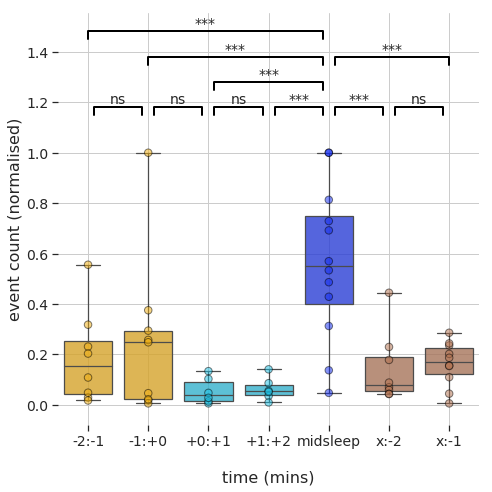

In [64]:
f, (ax1) = plt.subplots(ncols=1, figsize=(7, 7))

sns.boxplot(x='time_label', y='counts', data=allprobbincount_df,  
            whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette=color_dict)

sns.stripplot(x='time_label', y='counts', data=allprobbincount_df, jitter=False, linewidth=1,
              palette=color_dict,marker='o', s= 7.5, alpha = 0.5,edgecolor ="black")

string_val1 = 'ns'
string_val2 = '***'
statannotation(ax = ax1, x1 = 0.1, x2 = 0.9, y = 1.15, h = 0.125/4, text = string_val1)
statannotation(ax = ax1, x1 = 1.1, x2 = 1.9, y = 1.15, h = 0.125/4, text = string_val1)
statannotation(ax = ax1, x1 = 2.1, x2 = 2.9, y = 1.15, h = 0.125/4, text = string_val1)


statannotation(ax = ax1, x1 = 0, x2 = 3.9, y = 1.45, h = 0.125/4, text = string_val2)
statannotation(ax = ax1, x1 = 1, x2 = 3.9, y = 1.35, h = 0.125/4, text = string_val2)
statannotation(ax = ax1, x1 = 4.1, x2 = 6, y = 1.35, h = 0.125/4, text = string_val2)

statannotation(ax = ax1, x1 = 2.1, x2 = 3.9, y = 1.25, h = 0.125/4, text = string_val2)

statannotation(ax = ax1, x1 = 4.1, x2 = 4.9, y = 1.15, h = 0.125/4, text = string_val2)
statannotation(ax = ax1, x1 = 3.1, x2 = 3.9, y = 1.15, h = 0.125/4, text = string_val2)


statannotation(ax = ax1, x1 = 5.1, x2 = 5.9, y = 1.15, h = 0.125/4, text = string_val1)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
    
sns.despine(left=True, bottom = True)

ax1.set_ylabel('event count (normalised)', fontsize=label_fontsize)
ax1.set_xlabel('\ntime (mins)', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)

plt.suptitle('',fontsize=label_fontsize)

plt.tight_layout()
plt.box(False)

In [65]:
print('percent of events in 1st 2 mins', 100*sum(i <= 2 for i in allprobdepthcounts)/len(allprobdepthcounts))

percent of events in 1st 2 mins 9.11086717892426


In [66]:
sleepbins = pd.DataFrame({'depth': allprobdepthcounts, 'time':allprobdepthcats})
sleepbins['time_label'] = sleepbins['time'].map(timelabel_dict)

In [67]:
sleepbins['time_label'].value_counts()

midsleep    594
x:-1        156
x:-2         79
+1:+2        53
+0:+1        29
Name: time_label, dtype: int64

In [68]:
sleepbins['time_label'].value_counts(normalize = True)

midsleep    0.652031
x:-1        0.171240
x:-2        0.086718
+1:+2       0.058178
+0:+1       0.031833
Name: time_label, dtype: float64

In [69]:
print('min sleep depth for +0:+1', np.min(sleepbins[sleepbins['time_label'] == '+0:+1']['depth']))
print('max sleep depth for +0:+1', np.max(sleepbins[sleepbins['time_label'] == '+0:+1']['depth']))

min sleep depth for +0:+1 0.03333333333333333
max sleep depth for +0:+1 0.9666666666666667


In [70]:
print('min sleep depth for +1:+2', np.min(sleepbins[sleepbins['time_label'] == '+1:+2']['depth']))
print('max sleep depth for +1:+2', np.max(sleepbins[sleepbins['time_label'] == '+1:+2']['depth']))

min sleep depth for +1:+2 1.0
max sleep depth for +1:+2 1.9666666666666666


In [71]:
print('min sleep depth for midsleep', np.min(sleepbins[sleepbins['time_label'] == 'midsleep']['depth']))
print('max sleep depth for midsleep', np.max(sleepbins[sleepbins['time_label'] == 'midsleep']['depth']))

min sleep depth for midsleep 2.0
max sleep depth for midsleep 30.3


In [72]:
print('min sleep depth for x:-2', np.min(sleepbins[sleepbins['time_label'] == 'x:-2']['depth']))
print('max sleep depth for x:-2', np.max(sleepbins[sleepbins['time_label'] == 'x:-2']['depth']))

min sleep depth for x:-2 4.333333333333333
max sleep depth for x:-2 23.35


In [73]:
print('min sleep depth for x:-1', np.min(sleepbins[sleepbins['time_label'] == 'x:-1']['depth']))
print('max sleep depth for x:-1', np.max(sleepbins[sleepbins['time_label'] == 'x:-1']['depth']))

min sleep depth for x:-1 4.45
max sleep depth for x:-1 40.06666666666667


In [74]:
print('proboscis event -- 95th percentile(sleep depth) :', 
      np.round(np.percentile(sleepbins[sleepbins['time_label'] == 'midsleep']['depth'], 5),2))

proboscis event -- 95th percentile(sleep depth) : 2.47


In [75]:
# bins=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


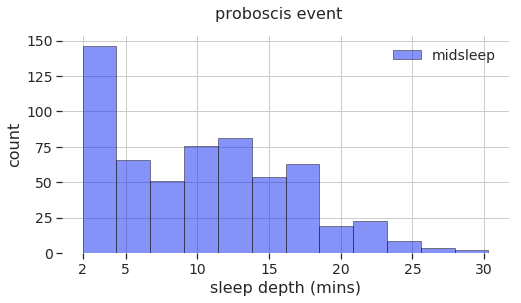

In [76]:
fig = plt.figure(figsize=(8, 4))
gs_main = gridspec.GridSpec(1, 1,width_ratios=[4])
gs_main.update(wspace=0.25, hspace=0.2)


gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])


ax1 = sns.histplot(data=sleepbins[sleepbins['time_label'] == 'midsleep'],
                   x="depth", hue="time_label", stat = 'count', kde = False, ax = ax1,  
                   palette=color_dict,edgecolor="k", alpha = 0.5, linewidth=0.5)
# ax1 = sns.histplot(data=sleepbins[sleepbins['time_label'] != 'midsleep'], bins = bins,
#                    x="depth", hue="time_label", stat = 'count', kde = False, ax = ax1,  
#                     palette=color_dict,edgecolor="k", alpha = 0.75, linewidth=0.5)

ax1.grid(True)

ax1.set_ylabel('count', fontsize=label_fontsize)
ax1.set_xlabel('sleep depth (mins)', fontsize=label_fontsize)
ax1.set_xticks([2, 5, 10, 15, 20, 25, 30])
# ax1.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07])
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.legend(labels = ['midsleep'], prop={'size': label_fontsize-2},frameon=False)

sns.despine(left=True, bottom=True, right=True)


plt.suptitle('proboscis event',fontsize=label_fontsize)

plt.tight_layout()
plt.box(False)